In [ ]:
import numpy as np
from PIL import Image
import tensorflow as tf
from matplotlib import pyplot as plt
import os
from sklearn.model_selection import train_test_split
groups_folder_path = "./sample_data/images/dachshund/"
groups_folder_path1 = "./sample_data/images/ducks/"
groups_folder_path2 = "./sample_data/images/fish/"


def imglist(groups_folder_path_name):
    img_list = []
    for x in os.listdir(groups_folder_path_name):
      if x != '.ipynb_checkpoints':
        image_filename = groups_folder_path_name + x
        img = Image.open(image_filename)
        size = (256, 256)
        img = img.resize(size)
        img = np.array(img)
        img_list.append(img)
    return img_list

a = imglist(groups_folder_path)
b = imglist(groups_folder_path1)
c = imglist(groups_folder_path2)
print(len(a), len(b), len(c))

X = np.concatenate((a,b,c), axis = 0)

num_classes = 3
Y = []
for i in range(3):
  label = [0 for i in range(num_classes)]
  label[i] = 1
  for _ in range(21):
     Y.append(label)

Y = np.asarray(Y)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y)
print(X.shape, Y.shape)
X_test.shape, Y_test.shape


21 21 21
(63, 256, 256, 3) (63, 3)


((16, 256, 256, 3), (16, 3))

[1 0 0]
[0 1 0]
[0 1 0]
[0 0 1]
[0 1 0]


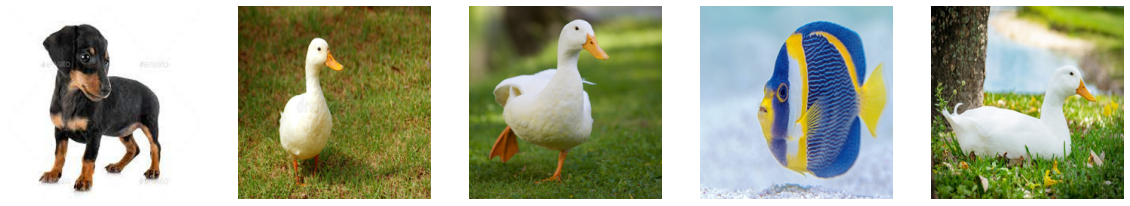

In [ ]:
fig,ax = plt.subplots(nrows=1,ncols=5,figsize=(20,20))
for i in range(5):
    ax[i].imshow(X_train[i])
    ax[i].axis('off')
    print(Y_train[i])

In [ ]:
def dep_bn(inputs):

  y = tf.keras.layers.Conv2D(filters = 32, kernel_size= 3, strides=1, padding= 'valid')(inputs)
  bn = tf.keras.layers.BatchNormalization(axis = 1)(y)
  relu = tf.keras.layers.ReLU()(bn)
  return relu 


def depthwise_block(x, filter : int, strides: int):


  #depthwise
  y = tf.keras.layers.DepthwiseConv2D(kernel_size= 3, strides= strides, padding= 'valid', depth_multiplier = 1)(x)
  bn = tf.keras.layers.BatchNormalization(axis = 1)(y)
  y_d = tf.keras.layers.ReLU()(bn)

  
  #pointwise
  y = tf.keras.layers.Conv2D(filters = filter, kernel_size= 1, strides=1, padding= 'valid')(y_d)
  bn = tf.keras.layers.BatchNormalization(axis = 1)(y)
  y_p = tf.keras.layers.ReLU()(bn)

  
  return y_p


In [ ]:
def create_mobilenet(inputs):


   bn = dep_bn(inputs)
   x = depthwise_block(bn, 64, 1)
   x = depthwise_block(x, 128, 2)
   x = depthwise_block(x, 128, 1)
   x = depthwise_block(x, 256, 2)
   x = depthwise_block(x, 256, 1)
   x = depthwise_block(x, 512, 1)
   x = depthwise_block(x, 512, 1)
   x = depthwise_block(x, 512, 1) 
   x = depthwise_block(x, 512, 1)
   x = depthwise_block(x, 1024, 2)
   x = depthwise_block(x, 1024, 1)
   t = tf.keras.layers.AveragePooling2D(1)(x)
   t = tf.keras.layers.Flatten()(t)
   outputs = tf.keras.layers.Dense(3, activation='softmax')(t)
   return outputs

   

In [ ]:
inputs = tf.keras.Input(shape=(X[0].shape[0], X[0].shape[0],3))
outputs = create_mobilenet(inputs)

model = tf.keras.Model(inputs, outputs)
EPOCHS = 30
INIT_LR = 1e-3
BS = 5
opt = tf.keras.optimizers.Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(
        optimizer=opt,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
#model.summary()
model.fit(
    X,
    Y,
    epochs=30,
    verbose=1,
    validation_data=(X_test, Y_test),
    batch_size=5
)

Epoch 1/30
13/13 [==============================] - 123s 9s/step - loss: 38.3179 - accuracy: 0.4286 - val_loss: 1.0981 - val_accuracy: 0.3125
Epoch 2/30
13/13 [==============================] - 116s 9s/step - loss: 27.7640 - accuracy: 0.6190 - val_loss: 1.1066 - val_accuracy: 0.3125
Epoch 3/30
13/13 [==============================] - 115s 9s/step - loss: 14.0341 - accuracy: 0.7460 - val_loss: 5.3519 - val_accuracy: 0.3125
Epoch 4/30
13/13 [==============================] - 115s 9s/step - loss: 13.2588 - accuracy: 0.7143 - val_loss: 8.4709 - val_accuracy: 0.3125
Epoch 5/30
13/13 [==============================] - 116s 9s/step - loss: 20.7002 - accuracy: 0.5873 - val_loss: 24.8399 - val_accuracy: 0.3125
Epoch 6/30
13/13 [==============================] - 115s 9s/step - loss: 14.2246 - accuracy: 0.7302 - val_loss: 17.5772 - val_accuracy: 0.3125
Epoch 7/30
13/13 [==============================] - 115s 9s/step - loss: 9.6928 - accuracy: 0.7143 - val_loss: 6.9761 - val_accuracy: 0.3125
Epoch

In [ ]:
predictions = model.predict(X_train[:5])
predictions

array([[3.1821382e-01, 2.9938218e-01, 3.8240406e-01],
       [1.0000000e+00, 5.3947101e-08, 3.4387949e-18],
       [2.1082931e-03, 9.9710089e-01, 7.9075975e-04],
       [1.1225240e-01, 1.3921993e-04, 8.8760841e-01],
       [1.0000000e+00, 1.7077919e-09, 1.6948226e-08]], dtype=float32)

In [ ]:

predictions = model.predict()

In [ ]:
def output_one_hot(prediction) :
    
   
    i = np.argmax(prediction)
    label_output = [0 for i in range(num_classes)]
    label_output[i] = 1
    return label_output

In [ ]:
onehot_output = []
for pred in predictions:
    
    onehot_output.append(output_one_hot(pred))
print(onehot_output[:5])

[[0, 0, 1], [1, 0, 0], [0, 1, 0], [0, 0, 1], [1, 0, 0]]
